# Predict Future Sales

---

## Import

In [1]:
# Basic packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots

# settings
import warnings
warnings.filterwarnings("ignore")

## Load data

In [2]:
# Import all of them 
sale_train=pd.read_csv("../data/sales_train.csv")

categories=pd.read_csv("../data/item_categories.csv")
items=pd.read_csv("../data/items.csv")
sub=pd.read_csv("../data/sample_submission.csv")
shops=pd.read_csv("../data/shops.csv")
test=pd.read_csv("../data/test.csv")

In [3]:
print("----------Top-5- Record----------")
print(sale_train.head(5))
print("-----------Information-----------")
print(sale_train.info())
print("-----------Data Types-----------")
print(sale_train.dtypes)
print("----------Missing value-----------")
print(sale_train.isnull().sum())
print("----------Null value-----------")
print(sale_train.isna().sum())
print("----------Shape of Data----------")
print(sale_train.shape)

----------Top-5- Record----------
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
-----------Information-----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None
-----------Data Types-----------
date               object
date_block_num  

In [4]:
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

sale_train = downcast_dtypes(sale_train)
print(sale_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int16  
 2   shop_id         int16  
 3   item_id         int16  
 4   item_price      float32
 5   item_cnt_day    float32
dtypes: float32(2), int16(3), object(1)
memory usage: 61.6+ MB
None


### Item_id

In [5]:
sales_by_item_id = sale_train.pivot_table(index=['item_id'],values=['item_cnt_day'], 
                                        columns='date_block_num', aggfunc=np.sum, fill_value=0).reset_index()
sales_by_item_id.columns = sales_by_item_id.columns.droplevel().map(str)
sales_by_item_id = sales_by_item_id.reset_index(drop=True).rename_axis(None, axis=1)
sales_by_item_id.columns.values[0] = 'item_id'

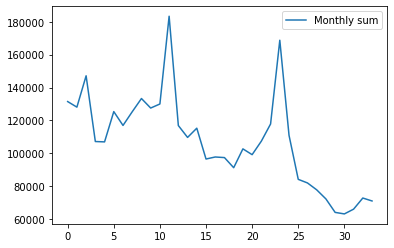

In [6]:
sales_by_item_id.sum()[1:].plot(legend=True, label="Monthly sum")

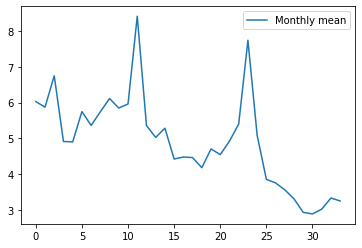

In [7]:
sales_by_item_id.mean()[1:].plot(legend=True, label="Monthly mean")

In [8]:
outdated_items = sales_by_item_id[sales_by_item_id.loc[:,'27':].sum(axis=1)==0]
print('Outdated items:', len(outdated_items))

Outdated items: 12391


In [9]:
print('Outdated items in test set:', len(test[test['item_id'].isin(outdated_items['item_id'])]))

Outdated items in test set: 6888


Sale volume outliers: [ 8057 20949  9242 19437  3731 11373  9249  9248]
Item price outliers: [11365  6066 13199]


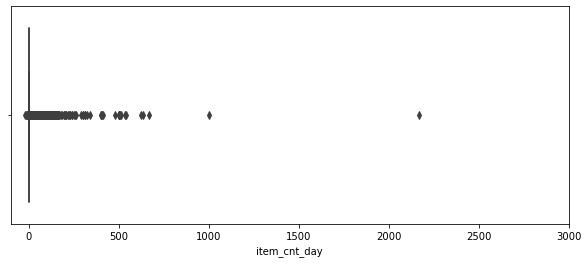

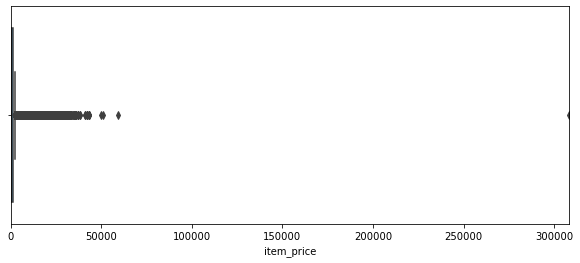

In [10]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=sale_train['item_cnt_day'])
print('Sale volume outliers:',sale_train['item_id'][sale_train['item_cnt_day']>500].unique())

plt.figure(figsize=(10,4))
plt.xlim(sale_train['item_price'].min(), sale_train['item_price'].max())
sns.boxplot(x=sale_train['item_price'])
print('Item price outliers:',sale_train['item_id'][sale_train['item_price']>50000].unique())

#### Possible item_id features:
1. Lags
2. Release date
3. Last month sale
4. Days on sale
5. Neighbors (items with id 1000 and 1001 could be somehow similar - genre, type, release date)

### shop_id

In [11]:
sales_by_shop_id = sale_train.pivot_table(index=['shop_id'],values=['item_cnt_day'], 
                                        columns='date_block_num', aggfunc=np.sum, fill_value=0).reset_index()
sales_by_shop_id.columns = sales_by_shop_id.columns.droplevel().map(str)
sales_by_shop_id = sales_by_shop_id.reset_index(drop=True).rename_axis(None, axis=1)
sales_by_shop_id.columns.values[0] = 'shop_id'

for i in range(6,34):
    print('Not exists in month',i,sales_by_shop_id['shop_id'][sales_by_shop_id.loc[:,'0':str(i)].sum(axis=1)==0].unique())

for i in range(6,28):
    print('Shop is outdated for month',i,sales_by_shop_id['shop_id'][sales_by_shop_id.loc[:,str(i):].sum(axis=1)==0].unique())

Not exists in month 6 [ 9 11 20 33 34 36 39 40 48 49]
Not exists in month 7 [ 9 11 20 33 34 36 39 40 48 49]
Not exists in month 8 [ 9 11 20 33 34 36 39 40 48 49]
Not exists in month 9 [11 20 33 34 36 39 40 48 49]
Not exists in month 10 [11 20 33 34 36 39 40 48 49]
Not exists in month 11 [11 20 33 34 36 39 40 48]
Not exists in month 12 [11 20 33 34 36 39 40 48]
Not exists in month 13 [11 20 33 34 36 39 40 48]
Not exists in month 14 [11 20 33 34 36 48]
Not exists in month 15 [11 20 33 34 36]
Not exists in month 16 [11 20 33 34 36]
Not exists in month 17 [11 20 33 34 36]
Not exists in month 18 [11 20 33 36]
Not exists in month 19 [11 20 36]
Not exists in month 20 [11 20 36]
Not exists in month 21 [11 36]
Not exists in month 22 [11 36]
Not exists in month 23 [11 36]
Not exists in month 24 [11 36]
Not exists in month 25 [36]
Not exists in month 26 [36]
Not exists in month 27 [36]
Not exists in month 28 [36]
Not exists in month 29 [36]
Not exists in month 30 [36]
Not exists in month 31 [36]


In [12]:
print('Recently opened shop items:', len(test[test['shop_id']==36]))

Recently opened shop items: 5100


#### Possible shop_id features
1. Lags (shop_id/shp_cnt_mth)
2. Opening month (possible opening sales)
3. Closed Month (possible stock elimination)

### Price

#### Possible Price features
1. Price category (1 /10 /20$/ etc.) - obviously (or not obviously), items with smaller price have greater volumes
2. Discount and Discount duration
3. Price lag (shows discount)
4. Price correction (rubl/usd pair)
5. Shop Revenue

### Dates

#### Possible Date features:
1. Weekends and holidays sales (to correct monthly sales)
2. Number of days in the month (to correct monthly sales)
3. Month number (for seasonal items)

### Shop info

In [13]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


Shop City | Shop type | Shop name

In [14]:
shops['shop_name'] = shops['shop_name'].apply(lambda x: x.lower()).str.replace('[^\w\s]', '').str.replace('\d+','').str.strip()
shops['shop_city'] = shops['shop_name'].str.partition(' ')[0]
shops['shop_type'] = shops['shop_name'].apply(lambda x: 'мтрц' if 'мтрц' in x else 'трц' if 'трц' in x else 'трк' if 'трк' in x else 'тц' if 'тц' in x else 'тк' if 'тк' in x else 'NO_DATA')
shops.head()

,shop_name,shop_id,shop_city,shop_type
0,якутск орджоникидзе фран,0,якутск,NO_DATA
1,якутск тц центральный фран,1,якутск,тц
2,адыгея тц мега,2,адыгея,тц
3,балашиха трк октябрькиномир,3,балашиха,трк
4,волжский тц волга молл,4,волжский,тц


#### Possible Shop features
1. Shop City
2. Shop Type

### Item info

In [15]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [16]:
from collections import Counter
from operator import itemgetter
items['name_1'], items['name_2'] = items['item_name'].str.split('[', 1).str
items['name_1'], items['name_3'] = items['item_name'].str.split('(', 1).str

items['name_2'] = items['name_2'].str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower()
items['name_3'] = items['name_3'].str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower()
items = items.fillna('0')

result_1 = Counter(' '.join(items['name_2'].values.tolist()).split(' ')).items()
result_1 = sorted(result_1, key=itemgetter(1))
result_1 = pd.DataFrame(result_1, columns=['feature', 'count'])
result_1 = result_1[(result_1['feature'].str.len() > 1) & (result_1['count'] > 200)]

result_2 = Counter(' '.join(items['name_3'].values.tolist()).split(" ")).items()
result_2 = sorted(result_2, key=itemgetter(1))
result_2 = pd.DataFrame(result_2, columns=['feature', 'count'])
result_2 = result_2[(result_2['feature'].str.len() > 1) & (result_2['count'] > 200)]

result = pd.concat([result_1, result_2])
result = result.drop_duplicates(subset=['feature'])

print('Most common aditional features:', result)

Most common aditional features:            feature  count
130   документация    284
131     английская    340
132        русские    399
133       субтитры    400
134            360    465
135          jewel    552
136           xbox    589
137            ps3    611
138        русская   1428
139       цифровая   1995
140             pc   2585
141         версия   3427
1981           box    246
1983            3d    409
1985           dvd    503
1986      digipack    541
1988          фирм    757
1991           mp3    854
1992            cd    871
1993        регион   1849
1994            bd   2320


In [17]:
print('Unique item names:', len(items['item_name'].unique()))

Unique item names: 22170


In [18]:
import re
def name_correction(x):
    x = x.lower()
    x = x.partition('[')[0]
    x = x.partition('(')[0]
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x)
    x = x.replace('  ', ' ')
    x = x.strip()
    return x

items['item_name'] = items['item_name'].apply(lambda x: name_correction(x))
items.head()

,item_name,item_id,item_category_id,name_1,name_2,name_3
0,во власти наваждения,0,40,! ВО ВЛАСТИ НАВАЖДЕНИЯ,0,пласт d
1,abbyy finereader 12 professional edition full,1,76,!ABBYY FineReader 12 Professional Edition Full...,pc цифровая версия,0
2,в лучах славы,2,40,***В ЛУЧАХ СЛАВЫ,0,unv d
3,голубая волна,3,40,***ГОЛУБАЯ ВОЛНА,0,univ d
4,коробка,4,40,***КОРОБКА,0,стекло d


#### Possible Item features
1. Item name
2. Encoded aditional feature

### Category info

In [19]:
categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


Section / Main Category name / Main SubCategory name / Secondary SubCategory name  
Аксессуары / PS2 / PS / 2

#### Possible Category features
1. Section
2. Main Category name
3. Main SubCategory name
4. Secondary SubCategory name

### Test Set

The key of success is the analysis of Test test data.  

We have three groups of items  
  
- Item/shop pairs that are in train
- Items without any data
- Items that are in train

In [20]:
good_sales = test.merge(sale_train, on=['item_id','shop_id'], how='left').dropna()
good_pairs = test[test['ID'].isin(good_sales['ID'])]
no_data_items = test[~(test['item_id'].isin(sale_train['item_id']))]

print('1. Number of good pairs:', len(good_pairs))
print('2. No Data Items:', len(no_data_items))
print('3. Only Item_id Info:', len(test)-len(no_data_items)-len(good_pairs))

1. Number of good pairs: 111404
2. No Data Items: 15246
3. Only Item_id Info: 87550
